In [1]:
## Our standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import joblib

## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
## set pandas to display more columns
pd.set_option('display.max_columns',50)
plt.style.use(('ggplot', 'tableau-colorblind10'))

# Data Dict

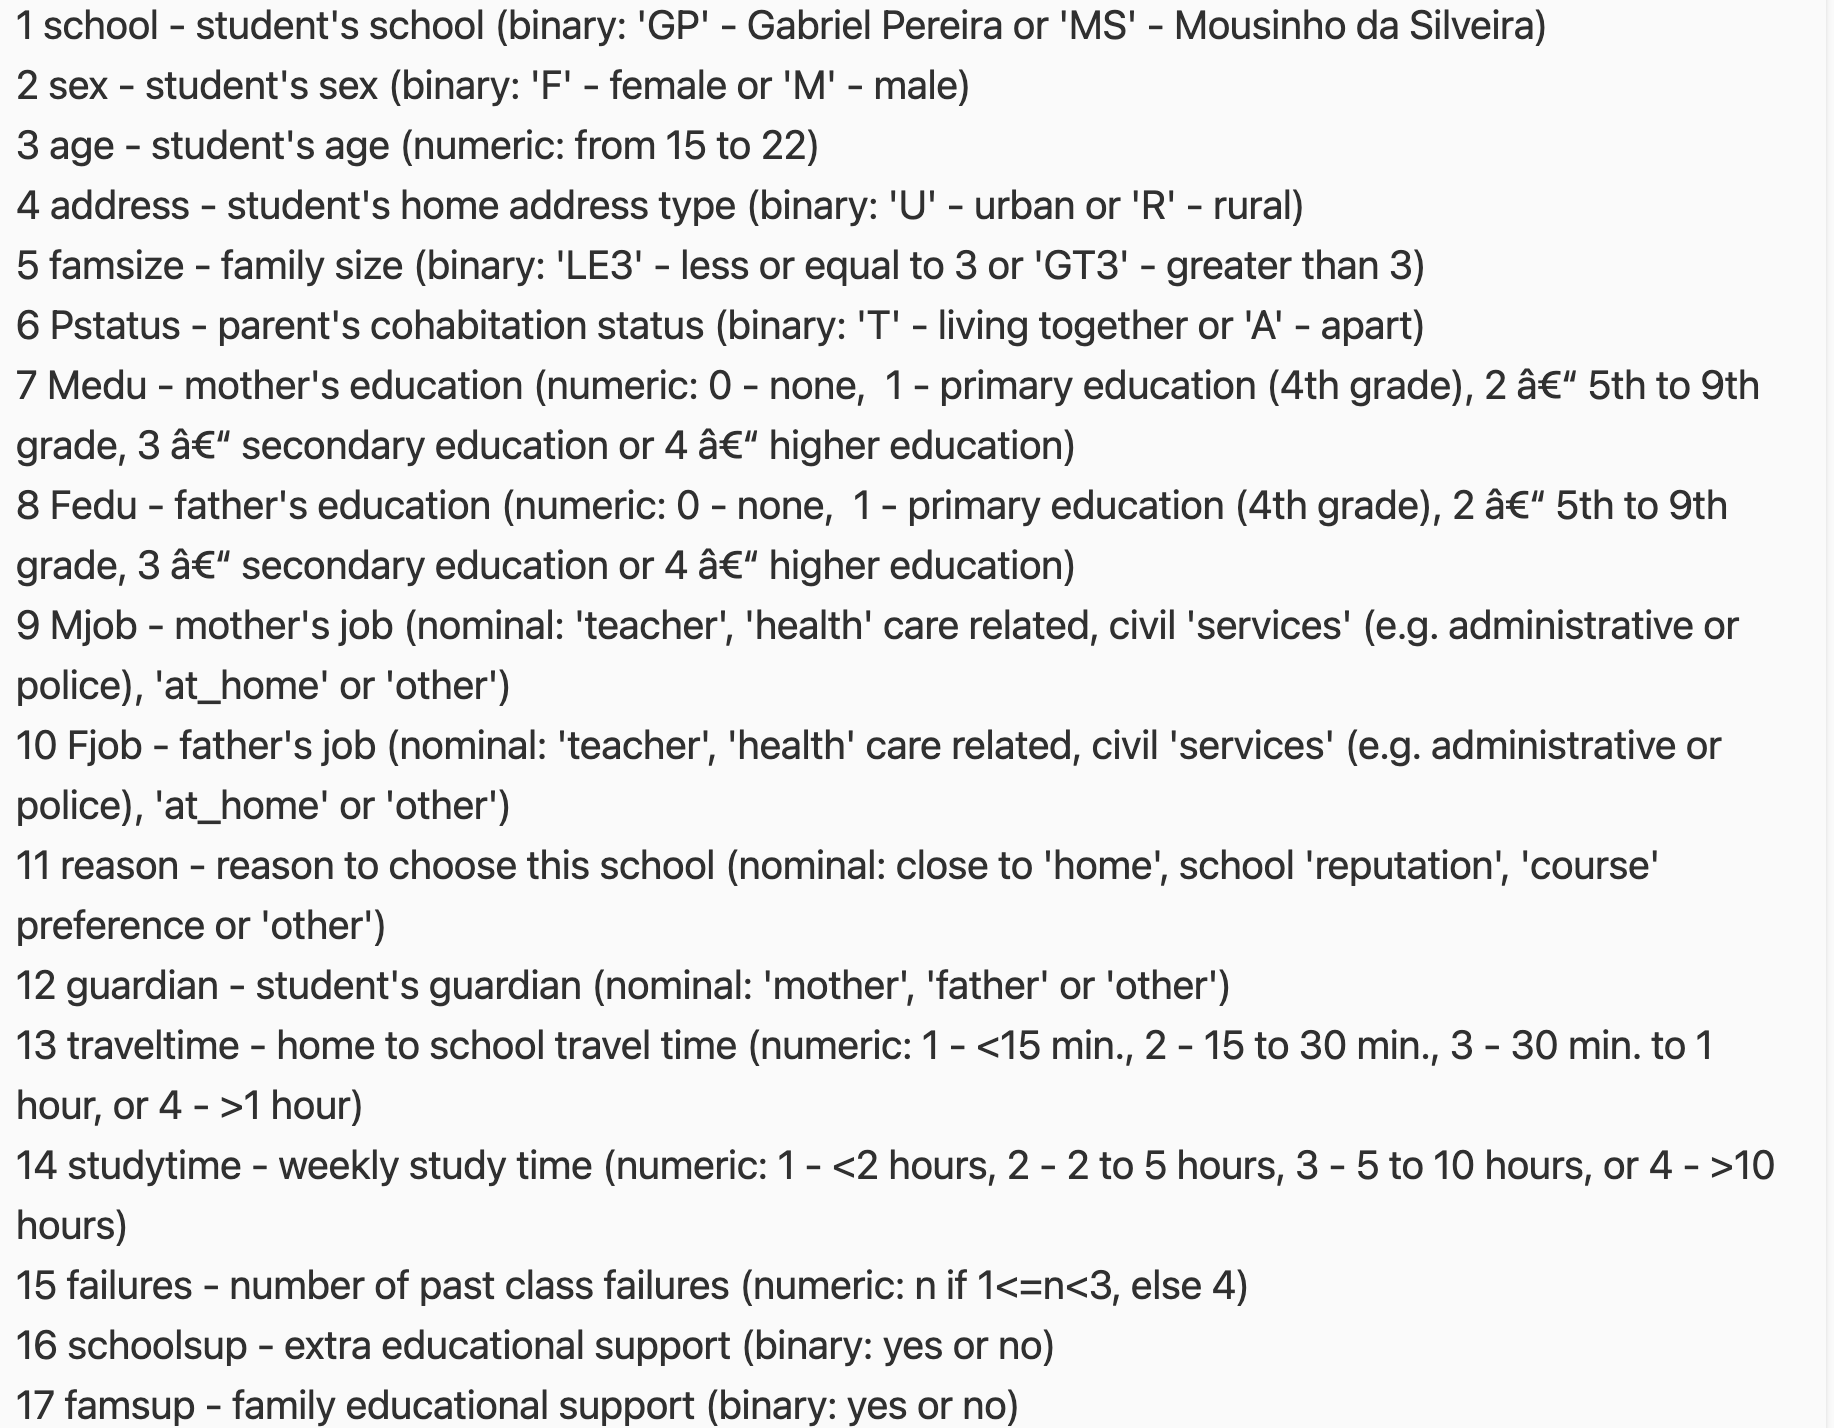

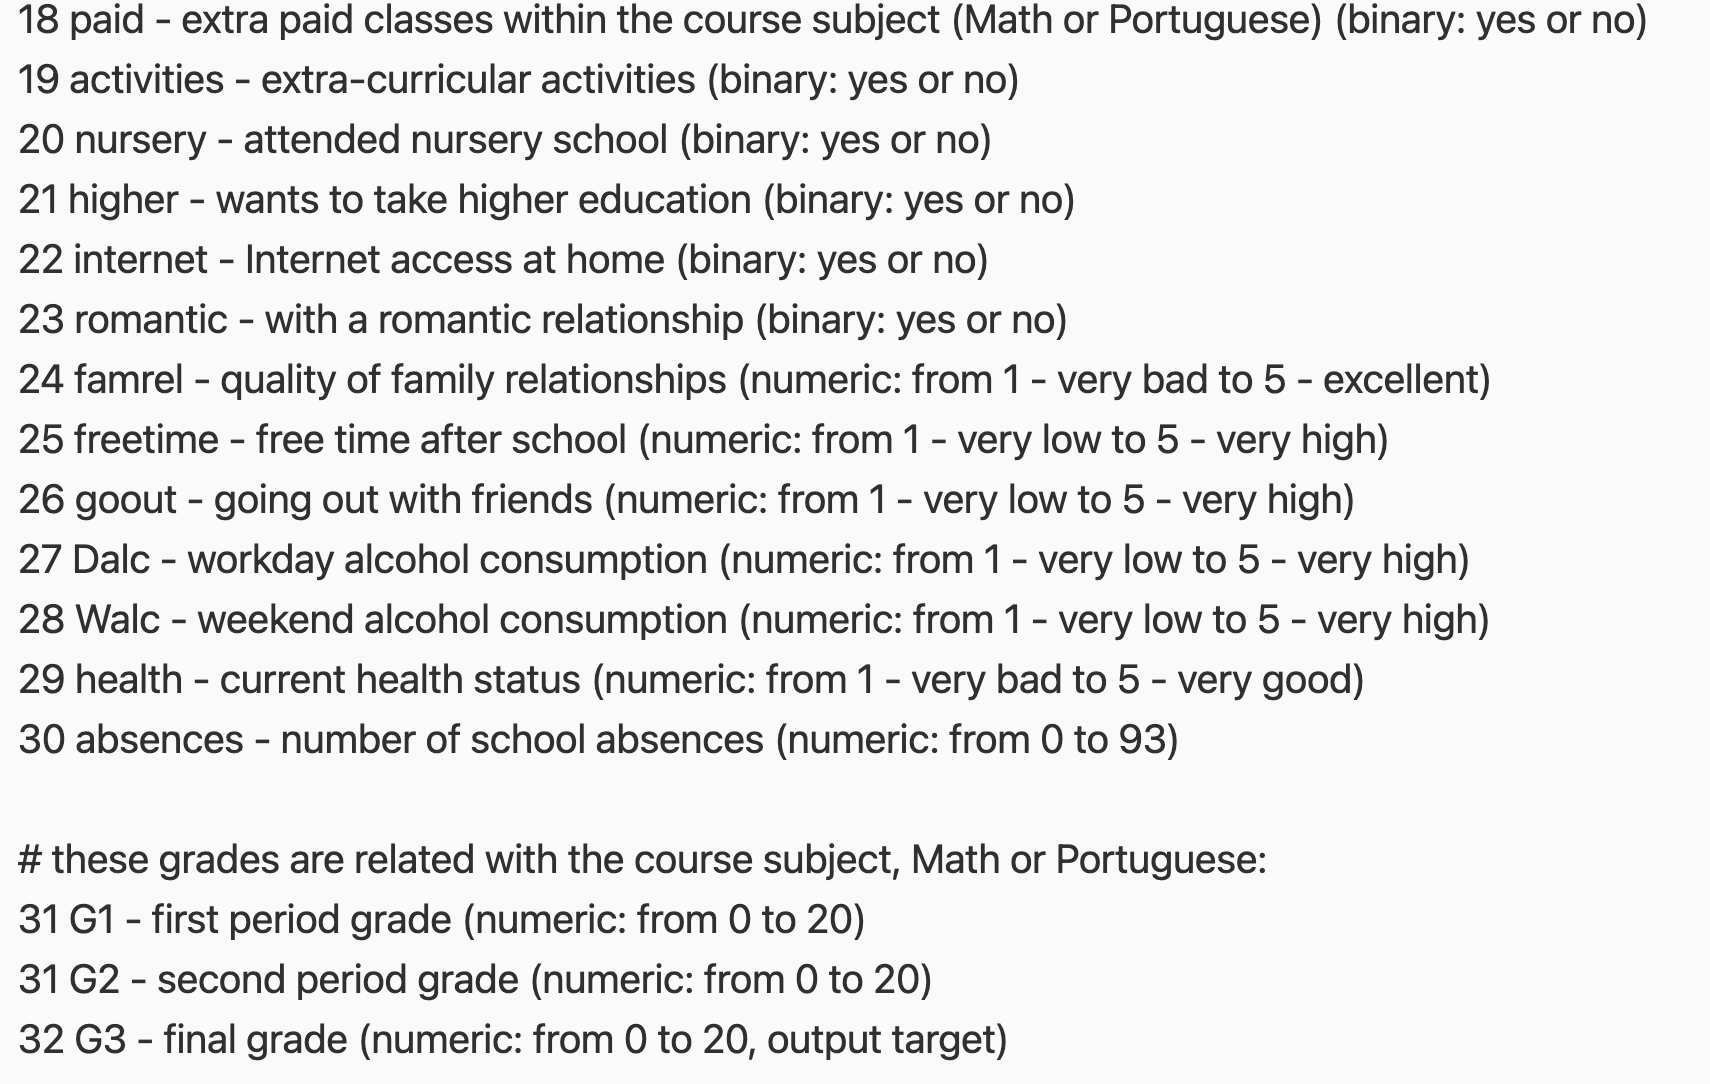

In [2]:
def evaluate_regression(model, X_train,y_train, X_test, y_test): 
    """Evaluates a scikit learn regression model using r-squared and RMSE"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    
    print(f"Training Data:\tR^2= {r2_train:.2f}\tRMSE= {rmse_train:.2f}")
        
    
    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    
    print(f"Test Data:\tR^2= {r2_test:.2f}\tRMSE= {rmse_test:.2f}")

In [3]:
def plot_coeffs(coeffs, top_n=None,  figsize=(4,5), intercept=False, 
                annotate=False, ha='left',va='center', size=12, xytext=(4,0),
                  textcoords='offset points'):
    """Plots the top_n coefficients from a Series, with optional annotations."""
    if (intercept==False) & ('intercept' in coeffs.index):
        coeffs = coeffs.drop('intercept')
    if top_n==None:
        ## sort all features and set title
        plot_vals = coeffs#.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        ## sort features and keep top_n and set title
        title = f"Top {top_n} Largest Coefficients"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Coefficient', 
           ylabel='Feature Names', 
           title=title)
    ax.axvline(0, color='k')
    
    if annotate==True:
        annotate_hbars(ax, ha=ha,va=va,size=size,xytext=xytext,
                       textcoords=textcoords)
    ## return ax in case want to continue to update/modify figure
    return ax

def annotate_hbars(ax, ha='left',va='center',size=12,  xytext=(4,0),
                  textcoords='offset points'):
    for bar in ax.patches:
    
        ## calculate center of bar
        bar_ax = bar.get_y() + bar.get_height()/2
        ## get the value to annotate
        val = bar.get_width()
        if val < 0:
            val_pos = 0
        else:
            val_pos = val
        # ha and va stand for the horizontal and vertical alignment
        ax.annotate(f"{val:.3f}", (val_pos,bar_ax), ha=ha,va=va,size=size,
                        xytext=xytext, textcoords=textcoords)

In [4]:
def plot_coeffs(coeffs, top_n=None, figsize=(4,5), 
                intercept=False, intercept_name="intercept", 
                annotate=False, ha='left', va='center', size=12, 
                xytext=(4,0), textcoords='offset points'):
    """ Plots the top_n coefficients from a Series, with optional annotations.
    """
    # Drop intercept if intercept=False and 
    if (intercept == False) & (intercept_name in coeffs.index):
        coeffs = coeffs.drop(intercept_name)
    if top_n == None:
        ## sort all features and set title
        plot_vals = coeffs.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)
        
        ## sort features and keep top_n and set title
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        title = f"Top {top_n} Largest Coefficients"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Coefficient', 
            ylabel='Feature Names', 
            title=title)
    ax.axvline(0, color='k')
    if annotate == True:
        annotate_hbars(ax, ha=ha, va=va, size=size, xytext=xytext, textcoords=textcoords)
    return ax

In [5]:
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vS6xDKNpWkBBdhZSqepy48bXo55QnRv1Xy6tXTKYzZLMPjZozMfYhHQjAcC8uj9hQ/pub?output=xlsx"
df = pd.read_excel(url,sheet_name='student-mat')
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,6,10,10


# Preprocessing the data

## A: Perform train-test-split with G3 as the target.


In [6]:
# train test split
## Make x and y variables
y = df['G3']
X = df.drop(columns=['G3'])
## train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=SEED)
X_train.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2
215,GP,F,17,U,LE3,T,3,2,other,other,reputation,mother,2,2,0,no,no,yes,no,yes,yes,yes,no,4,4,4,1,3,1,2,14,15
48,GP,M,15,U,GT3,T,4,2,teacher,other,home,mother,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,3,2,2,5,2,15,15
303,GP,F,17,U,GT3,T,3,2,health,health,reputation,father,1,4,0,no,yes,yes,yes,no,yes,yes,no,5,2,2,1,2,5,0,17,17
160,GP,M,17,R,LE3,T,2,1,at_home,other,course,mother,2,1,2,no,no,no,yes,yes,no,yes,yes,3,3,2,2,2,5,0,7,6
60,GP,F,16,R,GT3,T,4,4,health,teacher,other,mother,1,2,0,no,yes,no,yes,yes,yes,no,no,2,4,4,2,3,4,6,10,11


## B: Use a ColumnTransformer with the required preprocessing steps


In [7]:
## make pipelines for categorical vs numeric data
cat_sel=make_column_selector(dtype_include='object')
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(drop='if_binary', sparse=False))

num_sel=make_column_selector(dtype_include='number')
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))

## make the preprocessing column transformer
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),
                                      verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001DC411806D0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001DC41180670>)],
                  verbose_feature_names_out=False)

## C: Create DataFrame versions of your X_train and X_test data using the correct feature names.


In [8]:
## fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()

X_train_df = pd.DataFrame(preprocessor.transform(X_train), 
                          columns = feature_names, index = X_train.index)
X_train_df.head()

D:\Anaconda\envs\dojo-env\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
215,17.0,3.0,2.0,2.0,2.0,0.0,4.0,4.0,4.0,1.0,3.0,1.0,2.0,14.0,15.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0
48,15.0,4.0,2.0,1.0,2.0,0.0,4.0,3.0,3.0,2.0,2.0,5.0,2.0,15.0,15.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
303,17.0,3.0,2.0,1.0,4.0,0.0,5.0,2.0,2.0,1.0,2.0,5.0,0.0,17.0,17.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
160,17.0,2.0,1.0,2.0,1.0,2.0,3.0,3.0,2.0,2.0,2.0,5.0,0.0,7.0,6.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
60,16.0,4.0,4.0,1.0,2.0,0.0,2.0,4.0,4.0,2.0,3.0,4.0,6.0,10.0,11.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0


In [9]:
X_test_df = pd.DataFrame(preprocessor.transform(X_test), 
                          columns = feature_names, index = X_test.index)
X_test_df.head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
58,15.0,1.0,2.0,1.0,2.0,0.0,4.0,3.0,2.0,1.0,1.0,5.0,2.0,9.0,10.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
338,18.0,3.0,3.0,1.0,4.0,0.0,5.0,3.0,3.0,1.0,1.0,1.0,7.0,16.0,15.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
291,17.0,4.0,3.0,1.0,3.0,0.0,4.0,2.0,2.0,1.0,2.0,3.0,0.0,15.0,15.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
281,17.0,3.0,2.0,1.0,1.0,1.0,4.0,4.0,4.0,3.0,4.0,3.0,19.0,11.0,9.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
322,17.0,2.0,2.0,1.0,3.0,0.0,3.0,3.0,2.0,2.0,2.0,3.0,3.0,11.0,11.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


# Fit a tree-based model of your choice (that produces feature importances).

## A: Evaluate its performance on the training and test data.


In [10]:
reg = RandomForestRegressor(random_state=SEED)
reg.fit(X_train_df,y_train)
evaluate_regression(reg, X_train_df, y_train, X_test_df, y_test)

Training Data:	R^2= 0.98	RMSE= 0.66
Test Data:	R^2= 0.91	RMSE= 1.24


## B: extract and visualize the feature importances determined by the model.


In [11]:
## Saving the feature importances
importances = pd.Series(reg.feature_importances_, index= feature_names,
                       name='Feature Importance')
importances.head()

age           0.015323
Medu          0.004930
Fedu          0.004105
traveltime    0.002238
studytime     0.008951
Name: Feature Importance, dtype: float64

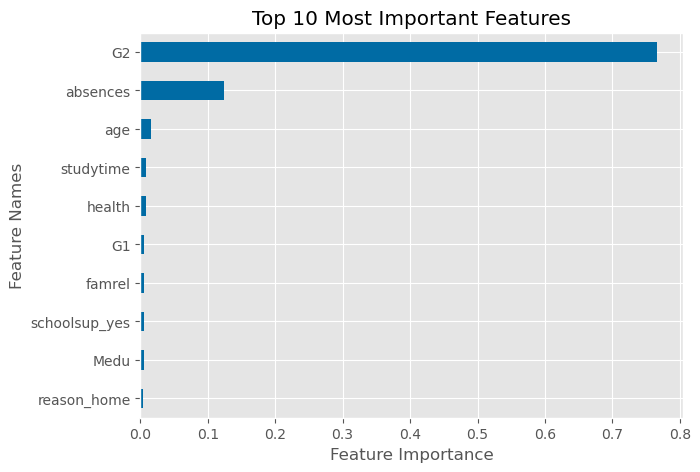

In [12]:
## Saving the feature importances sorted from smallest to largest (ascending=True)
sorted_importance = importances.sort_values()
## plotting top 10 importances and adding more spice
ax = sorted_importance.tail(10).plot(kind='barh',
                                    figsize=(7,5))
ax.set(xlabel='Feature Importance',
        ylabel='Feature Names',
        title='Top 10 Most Important Features');

## C: Answer what were the top 5 most important features?

From mo random forest model, it suggests the tope five most important features are G2, absences, age, famrel and health.


**What does it mean that they were "important"?**

An important feature is the one the often being used extensively and repeatedly by the model during the training process.

# Apply sklearn's permutation_importance

## A: visualize the permutation importances.


In [13]:
## Permutation importance takes a fit model and the test data.
r = permutation_importance(reg, X_train_df, y_train,n_repeats =5)
r.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [14]:
##  pull out the importances_mean and make it a Pandas Series 
## so it is easy to work with.
## can make the mean importances into a series
permutation_importances = pd.Series(r['importances_mean'],index=X_train_df.columns,
                           name = 'permutation importance')
permutation_importances = permutation_importances.sort_values(ascending=False)
permutation_importances.head()

G2           1.604643
absences     0.227329
age          0.020769
health       0.009680
studytime    0.007355
Name: permutation importance, dtype: float64

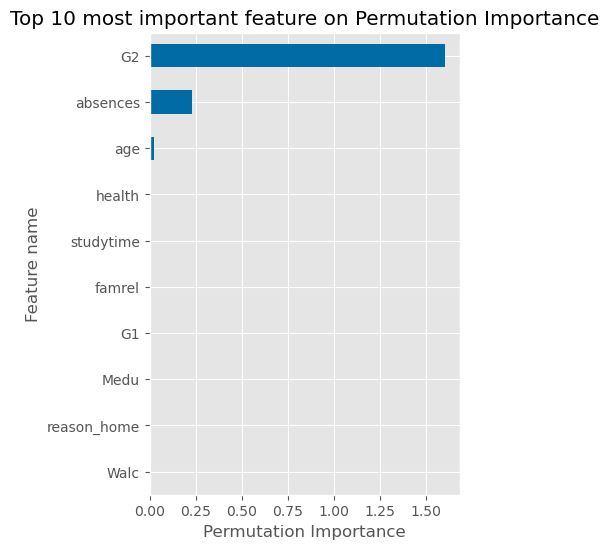

In [15]:
ax = permutation_importances.sort_values().tail(10).plot(kind='barh', figsize=(4,6))
ax.set(xlabel='Permutation Importance', ylabel='Feature name', 
       title='Top 10 most important feature on Permutation Importance');

## B: Answer what are the top 5 most important features the same as the top 5 most important features (according to our built-in importance)?

From same random forest model but in permutation importances, it suggests the top five most important features are G2, absences, age, G1 and fedu. It is different from feature importances. Among these four, they are all numeric.

# Fit a sklearn LinearRegression model

## A: Evaluate its performance on the training & test data.


In [16]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_df,y_train)
evaluate_regression(lin_reg, X_train_df, y_train, X_test_df,y_test)

Training Data:	R^2= 0.85	RMSE= 1.83
Test Data:	R^2= 0.81	RMSE= 1.85


## B: visualize the model's top 15 largest coefficients (according to absolute value).

In [17]:
coeffs = pd.Series(lin_reg.coef_, index=feature_names,
                        name='Coefficients')
coeffs.loc['intercept'] = lin_reg.intercept_
coeffs.head()

age          -0.220805
Medu          0.291554
Fedu         -0.178754
traveltime    0.187384
studytime    -0.215277
Name: Coefficients, dtype: float64

In [18]:
## rank the coeffs and select the top_n
top_n = 15
coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
top_n_features = coeff_rank.head(top_n).index
plot_vals = coeffs.loc[top_n_features].sort_values()
plot_vals

intercept        -0.948559
Fjob_services    -0.540326
reason_home      -0.417471
activities_yes   -0.338971
romantic_yes     -0.289609
Medu              0.291554
reason_other      0.299188
famrel            0.309943
Fjob_at_home      0.325395
schoolsup_yes     0.342220
Fjob_health       0.377169
school_MS         0.382554
Pstatus_T         0.384430
higher_yes        0.823032
G2                0.991225
Name: Coefficients, dtype: float64

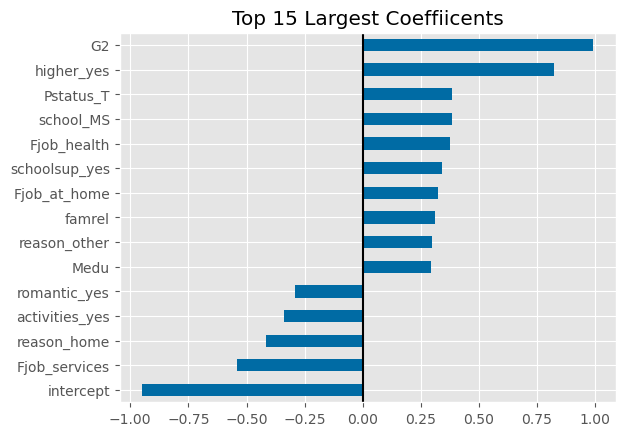

In [19]:
## Plot the coefficients
ax = plot_vals.sort_values().plot(kind='barh')#,figsize=(5,6))
ax.axvline(0,color='k')
ax.set_title(f'Top {top_n} Largest Coeffiicents');

## C: Select the 3 largest coefficients (by absolute value) and explain what they mean and what insights they might provide.


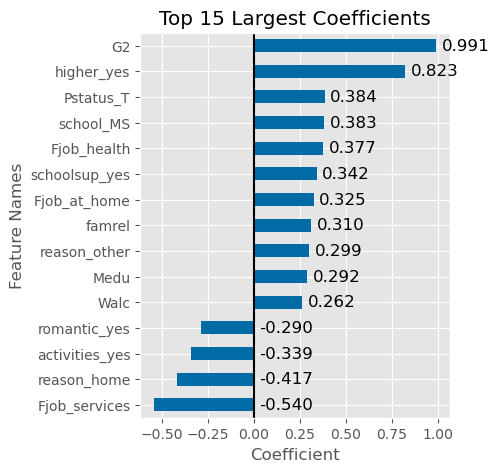

In [20]:
plot_coeffs(coeffs,top_n=15,intercept=False,annotate=True);

# Interpreting Our Model's Coefficients

- Intercept:
Our model assumed a baseline score of -.949

- Coefficients that Positively Influence Final Grade:
1. G2 "
for every 1 point increase in their G2 grade, their predicted G3 grade increases by .991 (out of 20).

2. higher_yes :
who intends to take higher education will increases their grade by .82

3. Pstatus_T:
 if the students parents live together, increases the predicted grade by .384.



- Coefficients that Negatively Influence Final Grade:
1. Fjob_services:
Father's job is civil service-orientated subtracted .54 points. That could be because the average education employment requirement is relative lower than other jobs.

2. reason_home :
student goes to school because close to home decreases the predicted score by .417. This could represent the effect of the student needs to spend much more effort to assist home duties and less time to study for exam.

3. activities_yes:
students with extra activities, the predicted score decreases by .339.



# random state =42

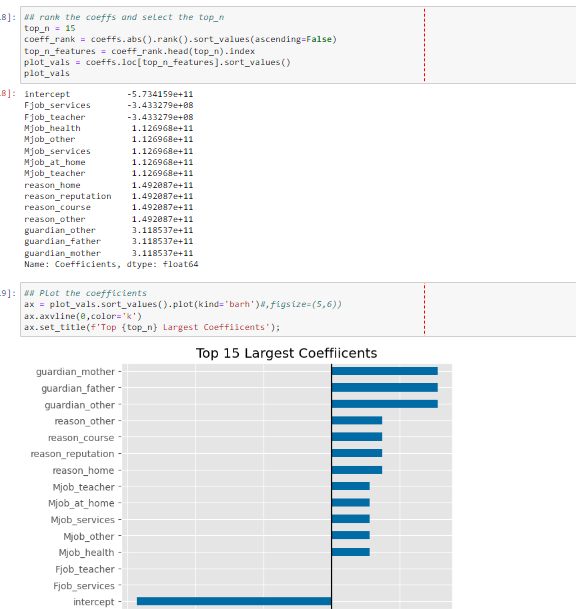

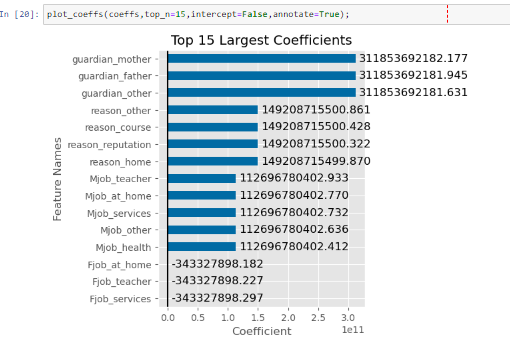